Copyright (c) 2024 Habana Labs, Ltd. an Intel Company.

##### Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License. You may obtain a copy of the License at https://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

## Using Hugging Face Pipelines on Intel&reg; Gaudi&reg; 2 - Visual Question Answering
This section showcases how to use the Hugging Face Transformers pipeline API to run visual question answering task on Intel Gaudi.

Hugging Face pipeline is an easy way to use models for inference. It is objects that abstract most of the complex code from the library, offering a simple API dedicated to several tasks. We choose "visual-question-answering" task here.    
Pipeline workflow is defined as a sequence of the following operations:

        Input -> Tokenization -> Model Inference -> Post-Processing (Task dependent) -> Output
Pipeline supports running on CPU or GPU through the device argument. Users can specify device argument, for example, we set device="hpu" in this case. "adapt_transformers_to_gaudi" will replace some Transformers' methods for equivalent methods optimized for Intel Gaudi.

### The First step is Install the Hugging Face Optimum Habana Library

In [ ]:
%cd ~/Gaudi-tutorials/PyTorch/Hugging_Face_pipelines
!pip install optimum-habana==1.14.0

### Import all neccessary dependencies and call adapt_transformers_to_gaudi()

In [1]:
import PIL.Image
import requests
import torch
from transformers import pipeline

from optimum.habana.transformers.modeling_utils import adapt_transformers_to_gaudi
from habana_frameworks.torch.hpu import wrap_in_hpu_graph

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3.10/inspect.py:288: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(object, types.FunctionType)
/usr/local/lib/python3.10/dist-packages/transformers/deepspeed.py:24: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(


The command below may be needed to modify the existing Hugging Face model classes to use the Intel Gaudi specific version of the model classes.

In [2]:
adapt_transformers_to_gaudi()

### Download and initialize the image

In [3]:
image_path = "https://free-images.com/md/3478/woman_dog_pacsi_paw.jpg"
image = PIL.Image.open(requests.get(image_path, stream=True, timeout=3000).raw).convert("RGB")

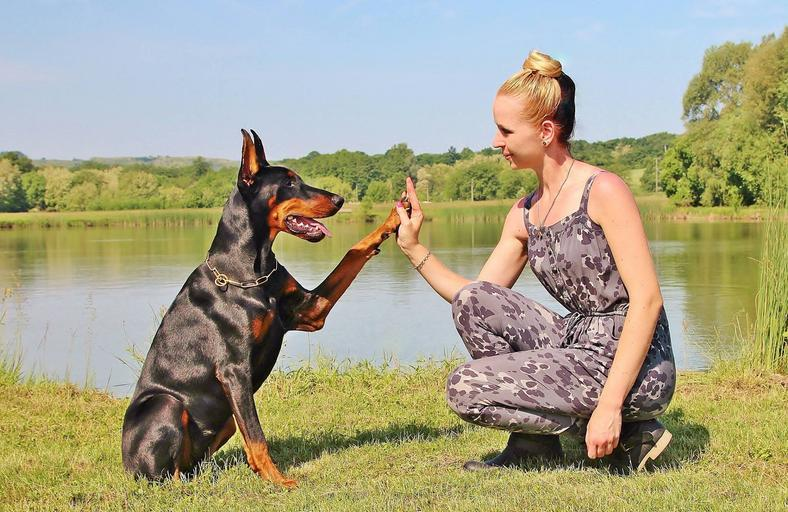

In [4]:
# Show the image, we'll be able to ask questions about this picture and get an answer
image

In [6]:
question = input("Enter a question about the image above: ")

Enter a question about the image above:  what breed is the dog?


Enter a question about the image above:  What is happening in this picture?

### Setup the pipeline
To setup the Hugging Face pipeline we set the following  
1. choose the Hugging Face task: for this, we use visual-question-answering.
2. Set the device to "hpu" which allows the pipeline to run on Intel Gaudi
3. Choose model "Salesforce/blip-vqa-capfilt-large" and data type to be bf16  

Finally we'll use the "wrap_in_hpu_graph" to wrap the module forward function with HPU Graphs. This wrapper captures, caches and replays the graph. More info [here](https://docs.habana.ai/en/latest/PyTorch/Inference_on_PyTorch/Inference_Using_HPU_Graphs.html).  

You will see that the Intel Gaudi will build the pipeline.

In [7]:
generator = pipeline("visual-question-answering", model="Salesforce/blip-vqa-capfilt-large", torch_dtype=torch.bfloat16, device="hpu")
generator.model = wrap_in_hpu_graph(generator.model)

============================= HABANA PT BRIDGE CONFIGURATION =========================== 
 PT_HPU_LAZY_MODE = 1
 PT_RECIPE_CACHE_PATH = 
 PT_CACHE_FOLDER_DELETE = 0
 PT_HPU_RECIPE_CACHE_CONFIG = 
 PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807
 PT_HPU_LAZY_ACC_PAR_MODE = 1
 PT_HPU_ENABLE_REFINE_DYNAMIC_SHAPES = 0
 PT_HPU_EAGER_PIPELINE_ENABLE = 1
 PT_HPU_EAGER_COLLECTIVE_PIPELINE_ENABLE = 1
---------------------------: System Configuration :---------------------------
Num CPU Cores : 160
CPU RAM       : 1056412772 KB
------------------------------------------------------------------------------


### Execute the Pipeline and Display the results

In [8]:
with torch.autocast(device_type="hpu", dtype=torch.bfloat16, enabled=torch.bfloat16):
    result = generator(image, question, batch_size=1, topk=1)

TypeError: set_autocast_enabled(): argument 'enabled' (position 2) must be bool, not torch.dtype

In [ ]:
print(question)
print("result = ", result)

In [ ]:
exit()